# Sander van de Kamp
#### 500734351 
#### 20/05/2021
# Auto Encoder

Een auto encoder bestaat uit een `Encoder` en een `Decoder`, de `encoder` wordt gebruikt om afbeeldingen te classificeren als een schatting welk getal het is, terwijl de `decoder` gebruikt wordt om deze schatting weer terug te zetten tot het oorspronkelijke getal. Deze twee modellen worden tegelijk samen getrained, aangezien de `encoder` moet gokken welk getal het is en de `decoder` moet leren hoe deze de getallen weer terug kan zetten tot de oorspronkelijke afbeelding.

In [18]:
import numpy as np

from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.optimizers import Adam
from keras.datasets import mnist
from keras.models import Model
from keras import backend as K

In [19]:

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
    
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

# afbeeldingen zijn allemaal 28 x 28
input_dim = (28, 28, 1)
z_dim = 2

### Encoder
De `encoder` bestaat drie convolutie lagen die er samen voor moeten zorgen dat de afbeeldingen geclassificeerd worden als een getal.

In [24]:
encoder_input = Input(input_dim, name = 'encoder_input')

x = Conv2D(filters = 32, kernel_size = 3, padding = 'same')(encoder_input)
x = LeakyReLU()(x)
x = Conv2D(filters = 64, kernel_size = 3, strides = (2,2), padding = 'same')(x)
x = LeakyReLU()(x)
x = Conv2D(filters = 128, kernel_size = 3, strides = (2,2), padding = 'same')(x)
x = LeakyReLU()(x)

shape_before_flattening = K.int_shape(x)[1:]

x = Flatten()(x)

encoder_output = Dense(z_dim, name = 'encoder_output')(x)
encoder = Model(encoder_input, encoder_output)
encoder.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 7, 7, 128)         73856     
_________________________________________________________________
leaky_re_lu_26 (LeakyReLU)   (None, 7, 7, 128)         0  

## Decoder
De decoder is het tegenovergestelde van de encoder, waarbij het probeert een afbeelding te maken door het tegenovergestelde van de encoder te doen. Het is mogelijk om deze twee niet dezelfde tegenovergestelde structuur te geven, alleen voelt het niet logisch voor mij om het te doen dus laat ik het zo.

In [25]:
decoder_input = Input((z_dim,), name = 'decoder_input')

x = Dense(np.prod(shape_before_flattening))(decoder_input)
x = Reshape(shape_before_flattening)(x) # van een dense vector naar de vorm van een afbeelding

x = Conv2DTranspose(filters = 128, kernel_size = 3, padding = 'same')(x)
x = LeakyReLU()(x)
x = Conv2DTranspose(filters = 64, kernel_size = 3, strides = (2,2), padding = 'same')(x)
x = LeakyReLU()(x)
x = Conv2DTranspose(filters = 32, kernel_size = 3, strides = (2,2), padding = 'same')(x)
x = LeakyReLU()(x)
x = Conv2DTranspose(filters = 1, kernel_size = 3, padding = 'same')(x)
x = LeakyReLU()(x)

decoder_output = Activation('sigmoid')(x)
decoder = Model(decoder_input, decoder_output)
decoder.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 2)]               0         
_________________________________________________________________
dense_3 (Dense)              (None, 6272)              18816     
_________________________________________________________________
reshape_3 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_8 (Conv2DTr (None, 7, 7, 128)         147584    
_________________________________________________________________
leaky_re_lu_27 (LeakyReLU)   (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 14, 14, 64)        73792     
_________________________________________________________________
leaky_re_lu_28 (LeakyReLU)   (None, 14, 14, 64)        0  

## De volledige autoencoder
De `decoder` wordt hier achter de `encoder` geplakt, waardoor het model getraint wordt om afbeeldingen af te breken en weer op te bouwen

In [26]:
autoencoder = Model(encoder_input, decoder(encoder_output))

learning_rate = 0.001
subset = 3000

def r_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred), axis = [1,2,3])

autoencoder.compile(optimizer = Adam(learning_rate = 0.01), loss = r_loss)
autoencoder.fit(x = x_train[:subset], y = x_train[:subset], batch_size = 32, epochs = 20, shuffle = True)

Epoch 1/20
94/94 [==============================] - 12s 93ms/step - loss: 0.1299
Epoch 2/20
94/94 [==============================] - 9s 92ms/step - loss: 0.1137
Epoch 3/20
94/94 [==============================] - 8s 89ms/step - loss: 0.1119
Epoch 4/20
94/94 [==============================] - 8s 87ms/step - loss: 0.1125
Epoch 5/20
94/94 [==============================] - 9s 96ms/step - loss: 0.1124
Epoch 6/20
94/94 [==============================] - 8s 89ms/step - loss: 0.1120
Epoch 7/20
94/94 [==============================] - 9s 91ms/step - loss: 0.1130
Epoch 8/20
94/94 [==============================] - 7s 72ms/step - loss: 0.1123
Epoch 9/20
94/94 [==============================] - 7s 70ms/step - loss: 0.1120
Epoch 10/20
94/94 [==============================] - 6s 68ms/step - loss: 0.1112
Epoch 11/20
94/94 [==============================] - 6s 67ms/step - loss: 0.1120
Epoch 12/20
94/94 [==============================] - 6s 67ms/step - loss: 0.1120
Epoch 13/20
94/94 [=================

## Reconstructie van originele afbeeldingen

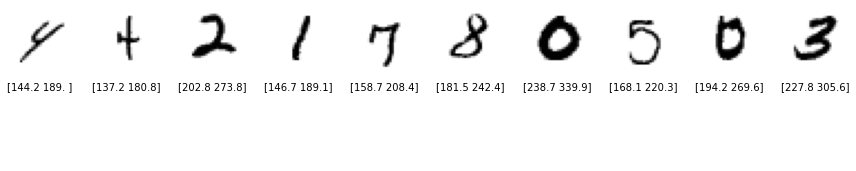

In [27]:
import matplotlib.pyplot as plt

n = 10

# selecteer willekeurige afbeeldingen uit x_test
idx = np.random.choice(range(len(x_test)), n)
test_images = x_test[idx]

# vertaal met de encoder naar getallen
z_points = encoder.predict(test_images)

# vertaal de getallen met de decoder terug naar afbeeldingen
reconstr_images = decoder.predict(z_points)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n):
    img = test_images[i].reshape((28,28))
    ax = fig.add_subplot(2, n, i + 1)
    ax.axis('off')
    ax.text(0.5, -0.35, str(np.round(z_points[i],1)), fontsize=10, ha='center', transform=ax.transAxes)   
    ax.imshow(img, cmap='gray_r')
    
for i in range(n):
    img = reconstr_images[i].reshape((28,28))
    ax = fig.add_subplot(2, n, i + n + 1)
    ax.axis('off')
    ax.imshow(img, cmap='gray_r')


Alles wat door de decoder gemaakt wordt is erg wazig en het enige dat duidelijk te zien is zijn de delen die altijd hetzelfde zijn, zoals het onderste deel van de 9 en de 4 of de 1 zelf.
## Plot van de encoder outputs
Hierop is te zien welke getallen de `encoder` vind, waar de `decoder` op getraint wordt om weer te reconstrueren.

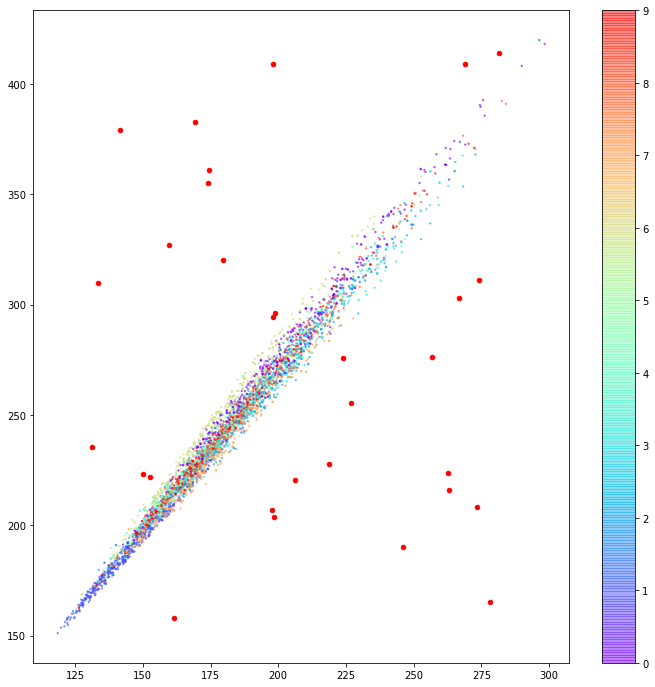

In [28]:
n = 5000
grid_size = 10
grid_depth = 3
figsize = 12

example_idx = np.random.choice(range(len(x_test)), n)
test_images = x_test[example_idx]
test_labels = y_test[example_idx]

z_points = encoder.predict(test_images)

min_x = min(z_points[:, 0])
max_x = max(z_points[:, 0])
min_y = min(z_points[:, 1])
max_y = max(z_points[:, 1])

plt.figure(figsize = (figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1] , cmap = 'rainbow' , c = test_labels, alpha = 0.5, s = 2)
plt.colorbar()

# willekeurige punten
x = np.random.uniform(min_x,max_x, size = grid_size * grid_depth)
y = np.random.uniform(min_y,max_y, size = grid_size * grid_depth)
z_grid = np.array(list(zip(x, y)))

plt.scatter(z_grid[:, 0] , z_grid[:, 1], c = 'red', alpha=1, s=20)
plt.show()

Wat valt je op aan bovenstaande plot met betrekking tot de verdeling van de labels?

De 0 en de 1 zitten allebei los van de groep, terwijl de rest van de getallen allemaal op een hoopje door elkaar zitten.

Wat valt je op aan bovenstaande plot met betrekking tot de willekeurig geselecteerde punten?

Er worden veel punten gekozen op gebieden waar geen getallen aanwezig zijn, waardoor de decoder ook op geen enkele manier een getal kan maken dat ergens op lijkt.

We gebruiken nu de `decoder` om op basis van de willekeurig gegenereerde punten volledig nieuwe afbeeldingen te genereren en plotten deze afbeeldingen.

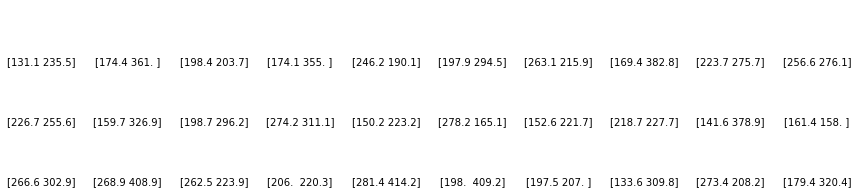

In [29]:
reconst = decoder.predict(z_grid)

figsize = 15
fig = plt.figure(figsize=(figsize, grid_depth))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_size*grid_depth):
    ax = fig.add_subplot(grid_depth, grid_size, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, str(np.round(z_grid[i],1)), fontsize=10, ha='center', transform=ax.transAxes)
    
    ax.imshow(reconst[i, :,:,0], cmap = 'Greys')

Wat valt je op aan deze afbeeldingen?

De meeste getallen blijven nogsteeds wazig, alleen zitten er een paar nu tussen die redelijk duidelijk zijn gemaakt. Alleen zitten er nu ook een paar tussen die niet eens in de buurt van een getal komen, dit komt hoogst waarschijnlijk dan ook doordat er een punt gekozen wordt die niet in de buurt ligt van één van de getallen.

Varieer nu eens met het aantal lagen en filters in de `encoder` en `decoder`. Kun je de `decoder` een volledig andere vorm geven dan de `encoder`? Hoe beïnvloed dit het resultaat?

Het verminderen van het aantal lagen heeft in ieder geval een flink negatief effect op het resultaat, een groot deel van de gokken lijken niet eens meer op getallen en degene die nog wel ergens op lijken zijn volledig wazig en lastig de identificeren.

In [13]:
encoder_input = Input(input_dim, name = 'encoder_input')

x = Conv2D(filters = 32,
           kernel_size = 3,
           padding = 'same',
           name = 'encoder_conv_1')(encoder_input)
x = LeakyReLU()(x)

x = Conv2D(filters = 64,
           kernel_size = 3,
           padding = 'same',
           name = 'encoder_conv_4')(x)
x = LeakyReLU()(x)

shape_before_flattening = K.int_shape(x)[1:]

x = Flatten()(x)

encoder_output = Dense(z_dim, name = 'encoder_output')(x)

encoder = Model(encoder_input, encoder_output)

encoder.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder_conv_1 (Conv2D)      (None, 28, 28, 32)        320       
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 28, 28, 32)        0         
_________________________________________________________________
encoder_conv_4 (Conv2D)      (None, 28, 28, 64)        18496     
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 28, 28, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 50176)             0         
_________________________________________________________________
encoder_output (Dense)       (None, 2)                 1003

In [14]:
decoder_input = Input((z_dim,), name = 'decoder_input')

x = Dense(np.prod(shape_before_flattening))(decoder_input)
x = Reshape(shape_before_flattening)(x) # van een dense vector naar de vorm van een afbeelding

x = Conv2DTranspose(filters = 64,
                kernel_size = 3,
                padding = 'same',
                name = 'decoder_conv_t_1')(x)
x = LeakyReLU()(x)

x = Conv2DTranspose(filters = 1,
                kernel_size = 3,
                padding = 'same',
                name = 'decoder_conv_t_4')(x)
x = LeakyReLU()(x)

decoder_output = Activation('sigmoid')(x)

decoder = Model(decoder_input, decoder_output)

decoder.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50176)             150528    
_________________________________________________________________
reshape_1 (Reshape)          (None, 28, 28, 64)        0         
_________________________________________________________________
decoder_conv_t_1 (Conv2DTran (None, 28, 28, 64)        36928     
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 28, 28, 64)        0         
_________________________________________________________________
decoder_conv_t_4 (Conv2DTran (None, 28, 28, 1)         577       
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 28, 28, 1)         0   

In [15]:
autoencoder = Model(encoder_input, decoder(encoder_output))

learning_rate = 0.0005

optimizer = Adam(lr = learning_rate)

def r_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred), axis = [1,2,3])

autoencoder.compile(optimizer = optimizer, loss = r_loss)

subset = 3000

autoencoder.fit(x = x_train[:subset], y = x_train[:subset], batch_size = 32, epochs = 20, shuffle = True)

Epoch 1/20
D:\Anaconda3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
94/94 [==============================] - 12s 111ms/step - loss: 0.1370
Epoch 2/20
94/94 [==============================] - 10s 106ms/step - loss: 0.0670
Epoch 3/20
94/94 [==============================] - 17s 177ms/step - loss: 0.0598
Epoch 4/20
94/94 [==============================] - 17s 176ms/step - loss: 0.0576
Epoch 5/20
94/94 [==============================] - 16s 173ms/step - loss: 0.0567
Epoch 6/20
26/94 [=======>......................] - ETA: 11s - loss: 0.0571

KeyboardInterrupt: 

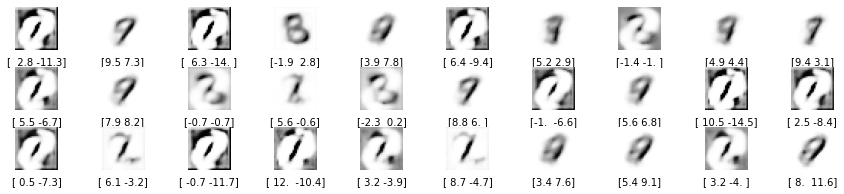

In [26]:
reconst = decoder.predict(z_grid)

figsize = 15
fig = plt.figure(figsize=(figsize, grid_depth))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_size*grid_depth):
    ax = fig.add_subplot(grid_depth, grid_size, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, str(np.round(z_grid[i],1)), fontsize=10, ha='center', transform=ax.transAxes)
    
    ax.imshow(reconst[i, :,:,0], cmap = 'Greys')